## According to a 2010 report made by the US Federal Aviation Administration, the economic price of domestic flight delays entails a yearly cost of 32.9 billion dollars to passengers, airlines and other parts of the economy. More than half of that amount comes from the pockets of passengers who not only lose time waiting for their planes to leave, but they also miss connecting flights, spend money on food and have to sleep on hotel rooms while they're stranded. 

## The report, focusing on data from year 2007, estimated that air transportation delays put a 4 billion dollar dent in the country's gross domestic product that year. Full report can be found [here](http://www.isr.umd.edu/NEXTOR/pubs/TDI_Report_Final_10_18_10_V3.pdf).

## But, what are the causes for these delays?

### In order to answer this question, we are going to analyze the provided dataset, containing up to 1.936.758 different internal flights in the US for 2008 and their causes for delay, diversion and cancellation; if any. 

### The data comes from the U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics (BTS). 

### The results are tentative.


# This dataset is composed by the following variables: 

1.	**Year**	2008
2.	**Month**	1-12
3.	**DayofMonth**	1-31
4.	**DayOfWeek**	1 (Monday) - 7 (Sunday)
5.	**DepTime**	actual departure time (local, hhmm)
6.	**CRSDepTime**	scheduled departure time (local, hhmm)
7.	**ArrTime**	actual arrival time (local, hhmm)
8.	**CRSArrTime**	scheduled arrival time (local, hhmm)
9.	**UniqueCarrier**	unique carrier code
10.	**FlightNum**	flight number
11.	**TailNum** plane tail number: aircraft registration, unique aircraft identifier
12.	**ActualElapsedTime**	in minutes
13.	**CRSElapsedTime**	in minutes
14.	**AirTime**	in minutes
15.	**ArrDelay**	arrival delay, in minutes: **A flight is counted as "on time" if it operated less than 15 minutes later the scheduled time shown in the carriers' Computerized Reservations Systems (CRS).** 
16.	**DepDelay**	departure delay, in minutes
17.	**Origin**	origin IATA airport code
18.	**Dest**	destination IATA airport code
19.	**Distance**	in miles
20.	**TaxiIn**	taxi in time, in minutes
21.	**TaxiOut**	taxi out time in minutes
22.	**Cancelled**	*was the flight cancelled
23.	**CancellationCode**	reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
24.	**Diverted**	1 = yes, 0 = no
25.	**CarrierDelay**	in minutes: Carrier delay is within the control of the air carrier. Examples of occurrences that may determine carrier delay are: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays.
26.	**WeatherDelay**	in minutes: Weather delay is caused by extreme or hazardous weather conditions that are forecasted or manifest themselves on point of departure, enroute, or on point of arrival.
27.	**NASDelay**	in minutes: Delay that is within the control of the National Airspace System (NAS) may include: non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc. 
28.	**SecurityDelay**	in minutes: Security delay is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.
29.	**LateAircraftDelay**	in minutes: Arrival delay at an airport due to the late arrival of the same aircraft at a previous airport. The ripple effect of an earlier delay at downstream airports is referred to as delay propagation.

# Index
## 1. Understanding and preparing the data
## 2. Exploratory Data analysis
### 2.1 Cancelled flights
### 2.2 Delayed flights
#### 2.2.1 Late Aircraft Delay
#### 2.2.2 Carrier Delays 
#### 2.2.3   NAS Delay
# 3. The situation today
# 4. A glimpse of the future


# 1. Understanding and preparing the the data

In [1]:
#import needed libraries & float format definition

import unicodecsv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy import stats
from scipy.stats import norm

pd.options.display.float_format = '{:.0f}'.format

In [2]:
# Reading and showing head data
flights = pd.read_csv("../input/DelayedFlights.csv")
flights.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003,1955,2211,2225,WN,...,4,8,0,N,0,nan,nan,nan,nan,nan
1,1,2008,1,3,4,754,735,1002,1000,WN,...,5,10,0,N,0,nan,nan,nan,nan,nan
2,2,2008,1,3,4,628,620,804,750,WN,...,3,17,0,N,0,nan,nan,nan,nan,nan
3,4,2008,1,3,4,1829,1755,1959,1925,WN,...,3,10,0,N,0,2,0,0,0,32
4,5,2008,1,3,4,1940,1915,2121,2110,WN,...,4,10,0,N,0,nan,nan,nan,nan,nan


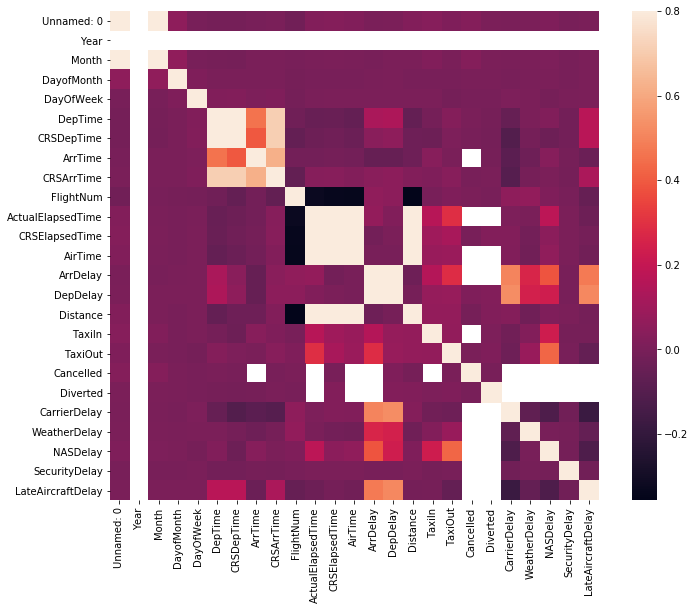

In [3]:
#correlation matrix
corrmat = flights.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

### Through the correlation matrix we can see how some of the 29 variables in the dataset present multicollinearity, in other words, can be linearly predicted from the others. In order to have a better analysis and work with a lighter dataset, we are going to delete some of those unwanted variables and create new ones.

### We can also make the following observations: 

#### 1. Only when Arrival Delay is longer than 15 minutes there's data about what caused the delay. Arrival Delay is the sum of CarrierDelay, WeatherDelay, NASDelay and LateAircraftDelay. In cases of cancelation or diversion there's no data related to delay causes. 

#### 2. More often than not, airports and carriers allocate a CRSElapsedTime higher than the actual time spent in the Taxi In + Taxi out + Airtime operations (Actual Elapsed Time). This is the reason why, when planes take off on time, landing usually takes place before the expected time! It also allows to absorb delay by late aircraft down the lane of chained flights. 

In [4]:

# creating new variables and renaming 
flights['DepDate'] = pd.to_datetime(flights.Year*10000+flights.Month*100+flights.DayofMonth,format='%Y%m%d')

#Status represents wether the flight was on time (0), slightly delayed (1), highly delayed (2), diverted (3), or cancelled (4)
for dataset in flights:
    flights.loc[flights['ArrDelay'] <= 15, 'Status'] = 0
    flights.loc[flights['ArrDelay'] >= 15, 'Status'] = 1
    flights.loc[flights['ArrDelay'] >= 60, 'Status'] = 2
    flights.loc[flights['Diverted'] == 1, 'Status'] = 3
    flights.loc[flights['Cancelled'] == 1, 'Status'] = 4
    
    
#Cancellation cause
flights.loc[flights["CancellationCode"] =="A", 'CancellationCode'] = "0"
flights.loc[flights["CancellationCode"] =="B", 'CancellationCode'] = "1"
flights.loc[flights["CancellationCode"] =="C", 'CancellationCode'] = "2"

# dropping the unwanted data   
flights = flights.drop("Unnamed: 0",1) #Empty
flights = flights.drop("Year",1) #Converted to date
flights = flights.drop("DayofMonth",1) #Converted to date
flights = flights.drop("DepTime",1) #Of the departure data we only keep the expected 
flights = flights.drop("DepDelay",1)
flights = flights.drop("ArrTime",1)
flights = flights.drop("CRSArrTime",1)
flights = flights.drop("ActualElapsedTime",1)
flights = flights.drop("CRSElapsedTime",1)
flights = flights.drop("Diverted",1)
flights = flights.drop("Cancelled",1)
flights = flights.drop("Distance",1)
flights = flights.drop("FlightNum",1)
flights = flights.drop("TailNum",1)

# 2. Exploratory Data analysis

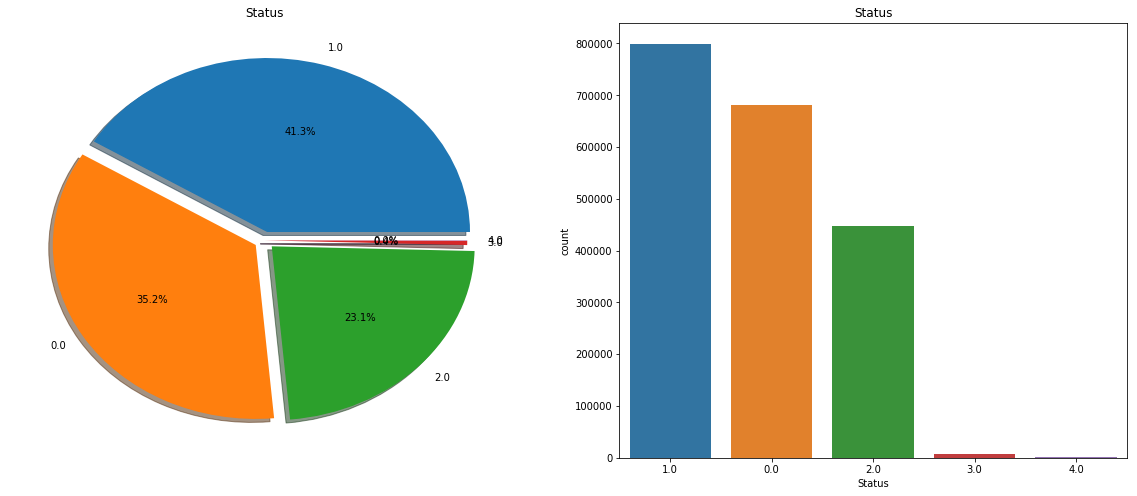

Status represents wether the flight was on time (0), slightly delayed (1), highly delayed (2), diverted (3), or cancelled (4)


In [5]:
f,ax=plt.subplots(1,2,figsize=(20,8))
flights['Status'].value_counts().plot.pie(explode=[0.05,0.05,0.05,0,0],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Status')
ax[0].set_ylabel('')
sns.countplot('Status',order = flights['Status'].value_counts().index, data=flights,ax=ax[1])
ax[1].set_title('Status')
plt.show()

print('Status represents wether the flight was on time (0), slightly delayed (1), highly delayed (2), diverted (3), or cancelled (4)')

### In 2008, a whooping 64,4% of domestic flights in the US were delayed by more than 15 minutes. 35,8% of them (or 23,1% of total fligths) had delays of more than one hour! Another different interpretation is that 76,5% of flights have delay of one hour or less. 

### On the other hand, just a 0,03% of flights were cancelled and 0,4% were diverted. 

## 2.1 Cancelled flights

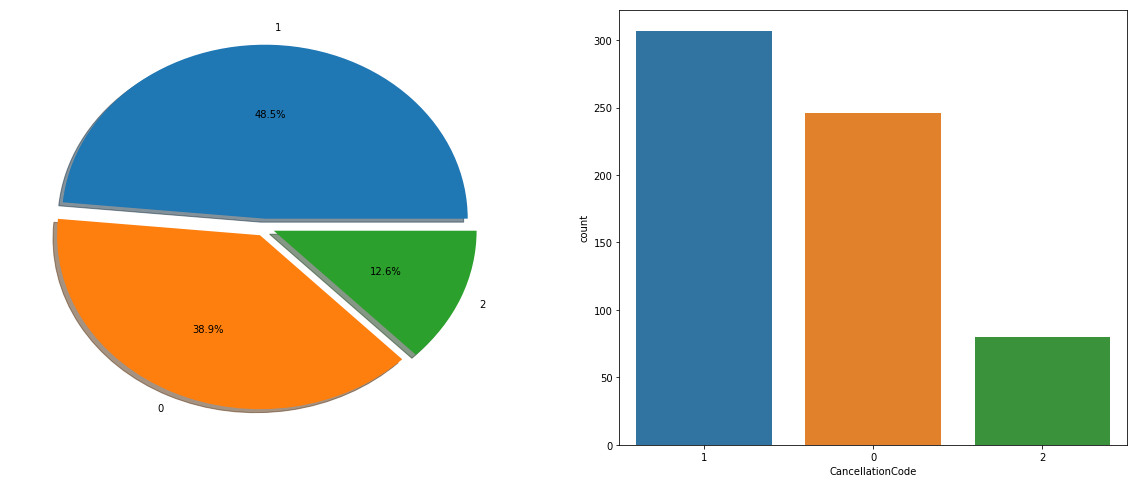

0 = carrier, 1 = weather, 2 = NAS


In [6]:
CancFlights = flights[(flights.Status == 4)]

f,ax=plt.subplots(1,2,figsize=(20,8))
CancFlights['CancellationCode'].value_counts().plot.pie(explode=[0.05,0.05,0.05,],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_ylabel('')
sns.countplot('CancellationCode', order = CancFlights['CancellationCode'].value_counts().index, data=CancFlights, ax=ax[1])
plt.show()


print('0 = carrier, 1 = weather, 2 = NAS')

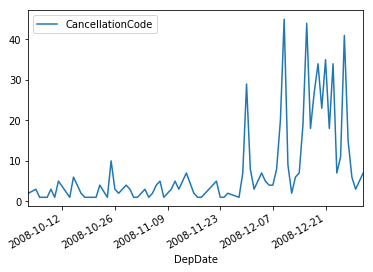

In [7]:
CancFlights[['DepDate','CancellationCode']].groupby(['DepDate']).count().plot()
plt.show()

### During 2008, there were only cancellations in the last three months of the year (from October to December). Doing a bit of research we find that 2008 winter was unusual, especially in December, with coast-to-coast severe winter weather, including one low pressure system from December 9-12 that brought snow to Houston and New Orleans, severe storms and flooding to other parts of the South, and an ice storm that left more than 1.27 million homes and business without power in the Northeast. 
### The bad weather might actually be the reason behind all the cancellations, since for rest of the year there are no registered cancellations at all. The compounded effect of the flights cancelled affect other programmed flights down the lane. 

## 1.2.2 Delayed flights

In [8]:
Delayedflights = flights[(flights.Status >= 1) &(flights.Status < 3)]

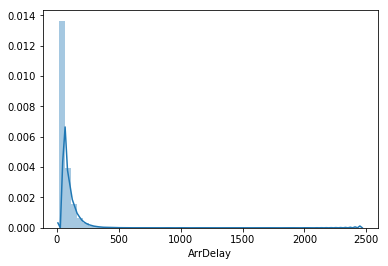

In [9]:
#histogram
sns.distplot(Delayedflights['ArrDelay'])
plt.show()

In [10]:
#skewness and kurtosis
print("Skewness: %f" % Delayedflights['ArrDelay'].skew())
print("Kurtosis: %f" % Delayedflights['ArrDelay'].kurt())

Skewness: 4.059856
Kurtosis: 40.381941


### It can be seen on the histogram and by the skewness and kurtosis indexes, that delays are mostly located on the left side of the graph, with a long tail to the right. The majority of delays are short, and the longer delays, while unusual, are more heavy loaded in time. 

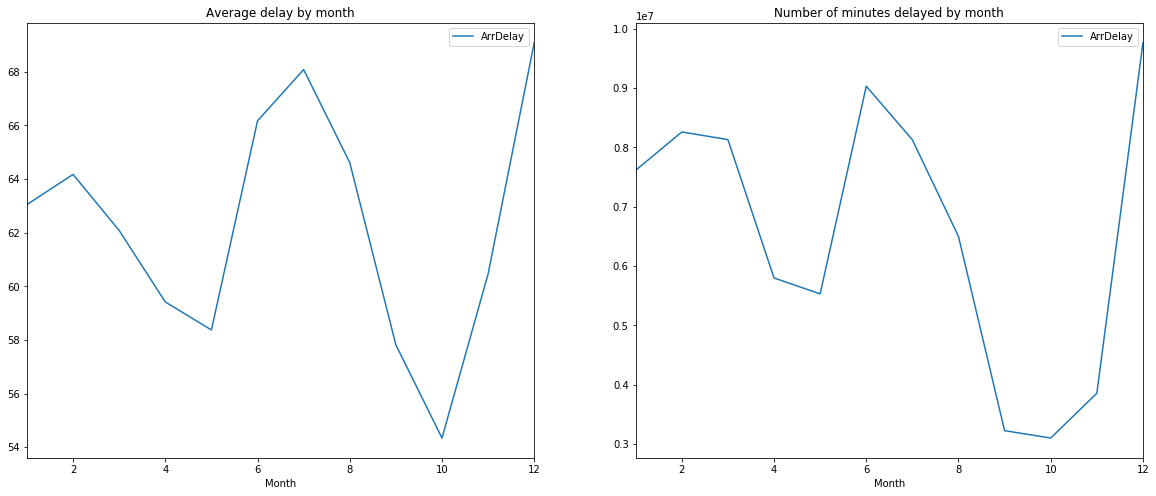

In [11]:
f,ax=plt.subplots(1,2,figsize=(20,8))
Delayedflights[['Month','ArrDelay']].groupby(['Month']).mean().plot(ax=ax[0])
ax[0].set_title('Average delay by month')
Delayedflights[['Month','ArrDelay']].groupby(['Month']).sum().plot(ax=ax[1])
ax[1].set_title('Number of minutes delayed by month')
plt.show()

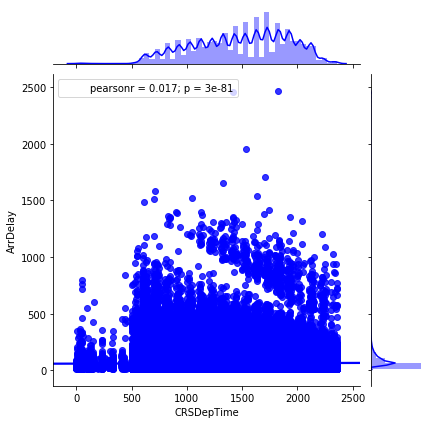

In [12]:
sns.jointplot(x='CRSDepTime',y='ArrDelay',data=Delayedflights,kind='reg', color='b',fit_reg = True)
plt.show()

### Delays focused on February, June and December, with a peak on average delays on July 2008.
### Regarding the time of the day the take off was programmed, it can be seen in the higher part of the scatterplot how the delays are concentrated in an hourly manner, focused on the hour. As the day goes on, there are more and more delays, but as it's shown in the center of the scatterplot, the delayed flights get divided into two groups: one with longer delays and other with shorter. One likely interpretation is that the delays generated by previous flights either increase or decrease in each following trip. 

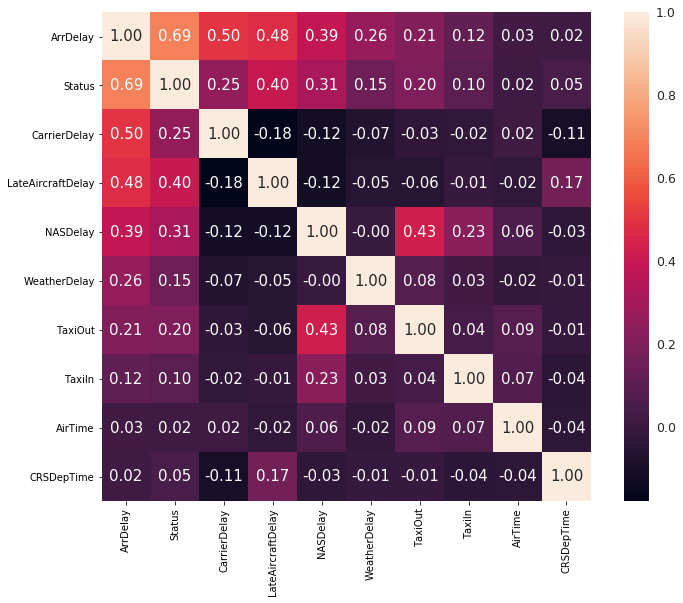

In [13]:
delcorrmat = Delayedflights.corr()

k = 10 #number of variables for heatmap
f, ax = plt.subplots(figsize=(12, 9))
cols = delcorrmat.nlargest(k, 'ArrDelay')['ArrDelay'].index
cm = np.corrcoef(Delayedflights[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

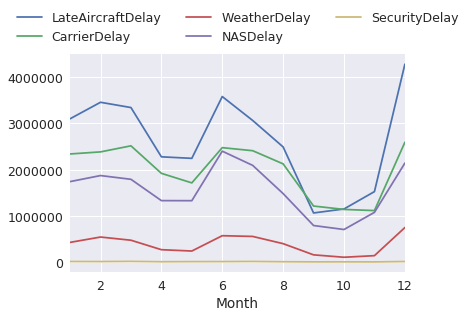

In [14]:
df2 = Delayedflights.filter(['Month','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay'], axis=1)
df2 = df2.groupby('Month')['LateAircraftDelay','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay'].sum().plot()
df2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3, fancybox=True, shadow=True)
plt.show()

### The correlation matrix identifies three main variables for delays: Late Aircraft Delay, Carrier Delay and NAS Delay. The graph corroborates this assumption, showing how those three variables create most of delays during the year. The variable Status can't be taken into account since it has been created 'ad hoc' and by it's own definition has a high correlation. 

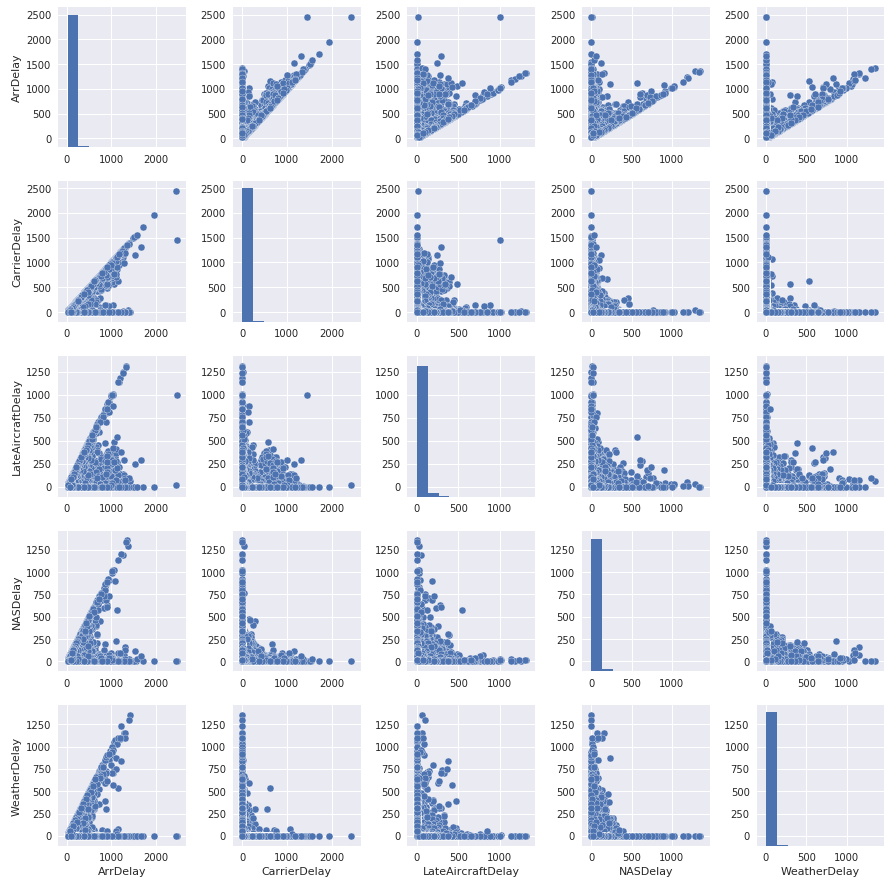

In [15]:
#scatterplot
sns.set()
cols = ['ArrDelay', 'CarrierDelay', 'LateAircraftDelay', 'NASDelay', 'WeatherDelay']
sns.pairplot(Delayedflights[cols], size = 2.5)
plt.show()

## 2.2.1 Late Aircraft Delay
### Late Aircraft Delay seems to be the most important variable, not only due to its longer wait periods, but it's affected by the others due to the ripple effect and delay propagation. Its distribution is almost parallel to NAS Delay, and seems to be the compounded effect of the other delays minus the delay reduction from the alloted Elapsed time > Actual Elapsed Time in the flight operations. 

### However, analyzing the scatterplot, it doesn't seem to be a significant correlation between the types of delay themselves. A more in depth analysis, following the exact routes of the aircrafts and their connections and subsequent flights could help identifying the exact root cause to each delay, but that is not within the scope of this analysis.

## 2.2.2 Carrier Delays 

In [16]:
print(flights['UniqueCarrier'].value_counts())

WN    377602
AA    191865
MQ    141920
UA    141426
OO    132433
DL    114238
XE    103663
CO    100195
US     98425
EV     81877
NW     79108
FL     71284
YV     67063
B6     55315
OH     52657
9E     51885
AS     39293
F9     28269
HA      7490
AQ       750
Name: UniqueCarrier, dtype: int64


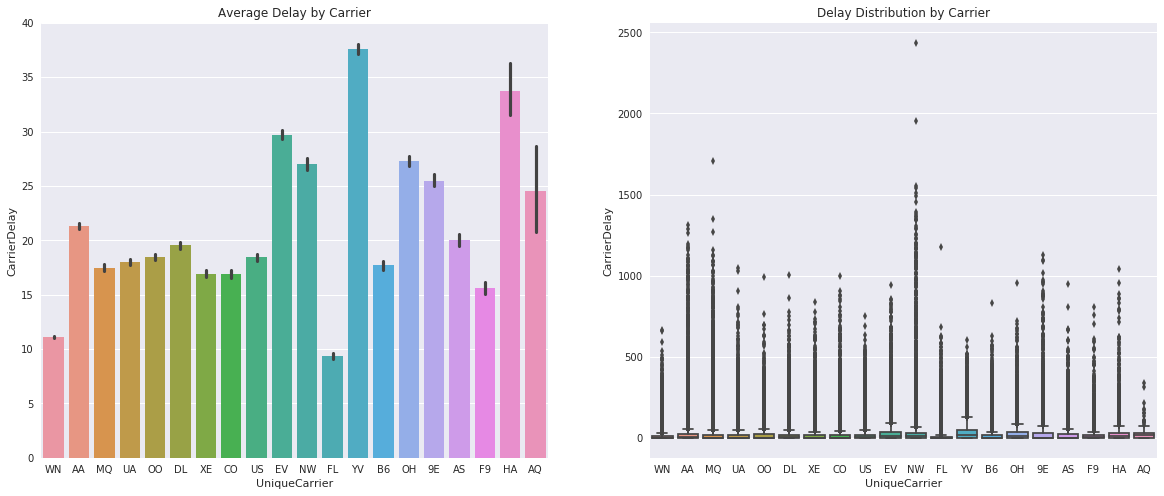

['WN: Southwest Airlines', 'AA: American Airlines', 'MQ: American Eagle Airlines', 'UA: United Airlines', 'OO: Skywest Airlines', 'DL: Delta Airlines', 'XE: ExpressJet', 'CO: Continental Airlines', 'US: US Airways', 'EV: Atlantic Southeast Airlines', 'NW: Northwest Airlines', 'FL: AirTran Airways', 'YV: Mesa Airlines', 'B6: JetBlue Airways', 'OH: Comair', '9E: Pinnacle Airlines', 'AS: Alaska Airlines', 'F9: Frontier Airlines', 'HA: Hawaiian Airlines', 'AQ: Aloha Airlines']


In [17]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('UniqueCarrier','CarrierDelay', data=Delayedflights,ax=ax[0], order=['WN', 'AA', 'MQ', 'UA','OO','DL','XE','CO',
                                                                                'US','EV', 'NW','FL','YV', 'B6','OH','9E',
                                                                                 'AS','F9','HA','AQ'])
ax[0].set_title('Average Delay by Carrier')
sns.boxplot('UniqueCarrier','CarrierDelay', data=Delayedflights,ax=ax[1], order=['WN', 'AA', 'MQ', 'UA','OO','DL','XE','CO',
                                                                                'US','EV', 'NW','FL','YV', 'B6','OH','9E',
                                                                                 'AS','F9','HA','AQ'])
ax[1].set_title('Delay Distribution by Carrier')
plt.close(2)
plt.show()

print(['WN: Southwest Airlines', 'AA: American Airlines', 'MQ: American Eagle Airlines', 'UA: United Airlines',
       'OO: Skywest Airlines','DL: Delta Airlines','XE: ExpressJet','CO: Continental Airlines','US: US Airways',
       'EV: Atlantic Southeast Airlines', 'NW: Northwest Airlines','FL: AirTran Airways','YV: Mesa Airlines', 
       'B6: JetBlue Airways','OH: Comair','9E: Pinnacle Airlines','AS: Alaska Airlines','F9: Frontier Airlines',
       'HA: Hawaiian Airlines','AQ: Aloha Airlines'])

### 4 from the top 5 companies in the domestic market (Southwest Airlines (WN), American Eagle Airlines (MQ), United Airlines (UA) and Skywest Airlines (OO) create an average delay below the mean (19 minutes). Southwest Airlines, with an outstanding 11.7 minutes per flight, the second lowest of all the carriers. 

### Carriers with higher average delay generation are Mesa Airlines (YV) with 37.63 minutes per flight, Hawaian Airlines (HA) with 33.76 minutes per flight and ExpressJet (EV) with 29,70. As we go from left to right in the barplot, it can be seen how airlines with lower volumen of flights tend to have a higher Carrier Delay (with the exception of AirTrans, integrated into Southwest in 2014); so it seems like size matters.

### On the other hand, taking responsibility of a higher number of flights results in a higher chance of having an extreme waiting situation. Northwest, American Eagle and American Airlines registered the maximum Carrier Delay for 2008.

## 2.2.3   NAS Delay

In [18]:
#Having more than 300 airports on the dataset, we are going to focus on the top20. 
Top20airports = Delayedflights[(Delayedflights.Origin == 'ORD') | (Delayedflights.Origin == 'ATL') |
                               (Delayedflights.Origin == 'DFW') | (Delayedflights.Origin == 'DEN') |
                               (Delayedflights.Origin == 'EWR') | (Delayedflights.Origin == 'LAX') | 
                               (Delayedflights.Origin == 'IAH') | (Delayedflights.Origin == 'PHX') |
                               (Delayedflights.Origin == 'DTW') | (Delayedflights.Origin == 'SFO') | 
                               (Delayedflights.Origin == 'LAS') | (Delayedflights.Origin == 'DEN') |
                               (Delayedflights.Origin == 'ORD') | (Delayedflights.Origin == 'JFK') | 
                               (Delayedflights.Origin == 'CLT') | (Delayedflights.Origin == 'LGA') |
                               (Delayedflights.Origin == 'MCO') | (Delayedflights.Origin == 'MSP') | 
                               (Delayedflights.Origin == 'BOS') | (Delayedflights.Origin == 'PHL')]

print(Top20airports['Origin'].value_counts())

ORD    90611
ATL    87741
DFW    62073
DEN    46477
EWR    36115
LAX    33713
IAH    33166
PHX    31002
DTW    30732
SFO    30110
LAS    30041
JFK    23870
CLT    23318
LGA    22807
MCO    22290
MSP    22149
BOS    19816
PHL    19302
Name: Origin, dtype: int64


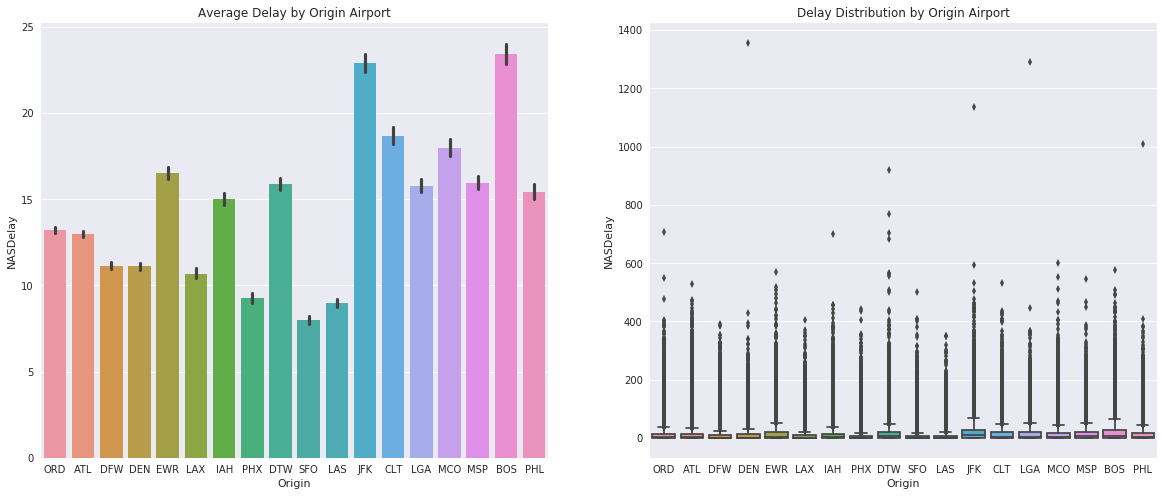

['ORD: Chicago', 'ATL: Atlanta', 'DFW: Dallas Fortworth', 'DEN: Denver', 'EWR: Newark', 'LAX: Los Ángeles', 'IAH: Houston', 'PHX: Phoenix', 'DTW: Detroit', 'SFO: San Francisco', 'LAS: Las Vegas', 'JFK: New York', 'CLT: Charlotte', 'LGA: La Guardia (NY)', 'MCO: Orlando', 'MSP: Minneapolis', 'BOS Boston', 'PHL Philadelphia']


In [19]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('Origin','NASDelay', data=Top20airports,ax=ax[0], order=['ORD', 'ATL', 'DFW', 'DEN','EWR','LAX','IAH','PHX','DTW',
                                                                     'SFO', 'LAS','JFK','CLT', 'LGA','MCO','MSP','BOS','PHL'])
ax[0].set_title('Average Delay by Origin Airport')
sns.boxplot('Origin','NASDelay', data=Top20airports,ax=ax[1], order=['ORD', 'ATL', 'DFW', 'DEN','EWR','LAX','IAH','PHX','DTW',
                                                                     'SFO', 'LAS','JFK','CLT', 'LGA','MCO','MSP','BOS','PHL'])
ax[1].set_title('Delay Distribution by Origin Airport')
plt.close(2)
plt.show()

print(['ORD: Chicago', 'ATL: Atlanta', 'DFW: Dallas Fortworth', 'DEN: Denver','EWR: Newark','LAX: Los Ángeles',
       'IAH: Houston','PHX: Phoenix','DTW: Detroit','SFO: San Francisco','LAS: Las Vegas','JFK: New York','CLT: Charlotte',
       'LGA: La Guardia (NY)','MCO: Orlando','MSP: Minneapolis','BOS Boston','PHL Philadelphia'])

### There seems to be a correlation between the number of flights operated and NASDelay, with the exceptions of Newark (EWR), Houston (IAH) and Detroit (DTW). From Chicago Airport  (ORD) to Las Vegas (LAS) a descending average NASDelay per flight can be seen. In less busy airports (less than 30.000 flights per year), delays increase once again. This seems to entail that there are two sizes of airport, and that the size,  the number of flights are correlated with the delays.  

### While this tendency might be true in some cases, this reasoning is flawed. The dataset is limited to domestic flights, but airports like LAX, JFK and Atlanta have a higher operations volume due to being notorious international airports, so we advise taking the conclusions with a pinch of salt. 

# 3. The situation today

### So far, we have seen causes for flight delay in 2008, but has the situation changed since then? 8 years later, in 2016, the ratio of domestic fligths in the US data offers a much brighter present. Numbers can be checked [here](https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp?pn=1). 

## Making a comparison between then and now, we can see how the numbers have improved (*): 

### On time: 35,2% in 2008 vs 81,42% in 2016.
### Delayed: 64,4% in 2008 vs 17,17% in 2016.
### Cancelled: 0,03% in 2008 vs 1,17% in 2016. 
### Diverted: 0,4% in 2008 vs 0,24% in 2016. 


#### (*) After searching for the reason behind this significant improvement in the last 8 years, we have compared the data offered on the BTS website for 2008 and 2016 and our dataset. The BTS ratios are based on datasets containing the averages by air carrier and origin airport, and they don't compare individual flights. Their sample consider nearly 20.000 flights. Our dataset, in comparison, contains around 2 million individual flights. 
#### The BTS data for 2008 is 76,04% flights on time, 21,75% delayed, 1,96% cancelled and 0,25% diverted. Taking into account these ratios, in the period between 2008 and 2016, there has been a 7% increase in the number of flights on time, an average of 0.875% each year. However, there's still a lot of room for improvement.

## 4. A glimpse into the future

### While the dataset itself doesn't offer a solution to the delay issue, it's clear that delay reduction has many intertwined variables. A solution applicable to one type of delay will heavily affect the others, resulting in a compounded effect that will allow more efficient operations; benefiting passengers, airports, carriers and even the world as a whole. 

### Here are some of the solutions to be seen on the near future:

### 5.1 LateAircraft and NAS Delay
#### Some experts, like Michael Baiada (retired pilot and President of ATH Group), argues that the solution to NAS Delay lies within the carriers. If carriers allowed aircrafts a higher speed and fuel consumption on planes that departed late, the effect wouldn't spread along the flight chain. This would decrease the NAS Delay itself and the Late Aircraft Delay, decreasing significatively the number of planes delayed. 
#### Find the full article [here](https://www.forbes.com/sites/currentaccounts/2017/03/23/air-traffic-control-is-not-the-real-cause-of-airline-delays/#33bb6ca2c375):

### 5.2 Better information efficiency
#### Amadeus, top GDS (Global Distribution Systems) and IT solutions provider to the travel industry identifies the approaches that Airlines, IT solutions and Big Data are taking in order to solve this issue. There's a paper on the issue in the following [link](http://www.amadeus.com/documents/airline/airline-disruption-management/amadeus-airline-it-disruption-white-paper.pdf).